### Learning a single weight in a student-teacher training paradigm with conductance-based neurons

In this notebook, we:

* Define a simple teacher network in which a single conductance-based neuron is driven by input Poisson spikes from a single feedforward neuron
* Initialise a student network with the same input but randomly initialised feedforward weight
* Train the student network to recover the weight using BPTT on the van Rossum loss

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define model parameters
dt = 1.0  # time step in ms
tau_m = 20.0  # membrane time constant in ms
tau_syn = 10.0  # synaptic time constant in ms
E_syn = 0.0  # synaptic reversal potential in mV
E_L = -60.0  # resting potential in mV
v_reset = -60.0  # reset potential in mV
theta = -38.0  # spike threshold in mV
g_L = 1.35  # leak conductance in nS
g_syn = 4.0  # synaptic conductance (per spike per weight) in nS

alpha = torch.exp(torch.tensor(-dt / tau_m))  # membrane decay factor
beta = torch.exp(torch.tensor(-dt / tau_syn))  # synaptic decay factor
C_m = tau_m * g_L  # membrane capacitance in nF

In [3]:
# Define the surrogate gradient function for spiking neurons


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 0.2  # Hardcoded surrogate gradient scale

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        (input,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

In [4]:
# Define teacher network
w = torch.tensor([0.5], requires_grad=False)  # synaptic weight
w_teacher = w.clone()  # Save the teacher weight

In [ ]:
# Define the feedforward neuron model
def conductance_neuron_step(
    v: torch.Tensor,
    g: torch.Tensor,
    s_in: torch.Tensor,
) -> torch.Tensor:
    """
    Single time step inference of conductance-based LIF neuron model with
    exponential synapses.

    Parameters:
    v: (batch,) membrane potential
    g: (batch,) synaptic conductance
    s_in: (batch,) input spike
    """

    # Update conductance
    g = g * beta + g_syn * w * s_in

    # Update membrane potential
    v = E_L + (v - E_L) * alpha - (g * (v - E_syn)) * dt / C_m

    # Compute spike
    s = SurrGradSpike.apply(v - theta)

    # Reset membrane potential
    v = v * (1 - s.detach()) + v_reset * s.detach()

    return v, g, s


def conductance_neuron(
    v_init: torch.Tensor,
    g_init: torch.Tensor,
    input_spikes: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, list, list]:
    """
    Multi time step inference of conductance-based LIF neuron model

    Parameters:
    v_init: (batch,) initial membrane potential
    g_init: (batch,) initial synaptic conductance
    input_spikes: (batch, time) input spikes

    Returns:
    v_rec: (batch, time) membrane potentials
    g_rec: (batch, time) conductances
    s_rec: (batch, time) spikes
    v_grads: list of (timestep, gradient) tuples for membrane potential
    g_grads: list of (timestep, gradient) tuples for conductance
    """
    time_steps = input_spikes.shape[1]

    # Initialize state variables
    v = v_init
    g = g_init

    # Record variables over time
    v_list = []
    g_list = []
    s_list = []

    # Store gradients here
    v_grads = []
    g_grads = []

    for t in range(time_steps):
        s_in = input_spikes[:, t]
        v, g, s = conductance_neuron_step(v, g, s_in)

        # Register hooks to capture gradients during backward pass
        if v.requires_grad:
            v.register_hook(lambda grad, t=t: v_grads.append((t, grad.clone())))
        if g.requires_grad:
            g.register_hook(lambda grad, t=t: g_grads.append((t, grad.clone())))

        v_list.append(v)
        g_list.append(g)
        s_list.append(s)

    # Stack into tensors
    v_rec = torch.stack(v_list, dim=1)  # (batch, time)
    g_rec = torch.stack(g_list, dim=1)  # (batch, time)
    s_rec = torch.stack(s_list, dim=1)  # (batch, time)

    return v_rec, g_rec, s_rec, v_grads, g_grads

In [6]:
# Create input spike trains (4 excitatory + 1 inhibitory)
duration = 10.0  # duration in seconds
time_steps = int(duration * 1000 / dt)

# Excitatory inputs: 4 neurons at 4, 6, 8, 10 Hz
firing_rates_exc = torch.tensor([4.0, 6.0, 8.0, 10.0])  # Hz
input_spikes_exc = torch.stack(
    [
        torch.bernoulli(torch.full((1, time_steps), rate * dt * 1e-3))
        for rate in firing_rates_exc
    ],
    dim=2,
)  # (1, time_steps, 4)

# Inhibitory inputs: 1 neuron at 6 Hz
firing_rate_inh = 6.0  # Hz
input_spikes_inh = torch.bernoulli(
    torch.full((1, time_steps, 1), firing_rate_inh * dt * 1e-3)
)

In [7]:
# Create input spike train
duration = 10.0  # duration in seconds
time_steps = int(duration * 1000 / dt)
firing_rate = 6.0  # firing rate in Hz

input_spikes = torch.bernoulli(torch.full((1, time_steps), firing_rate * dt * 1e-3))

In [8]:
# Simulate teacher network
v_init = torch.full((1,), E_L)
g_init = torch.zeros((1,))
v_teacher, g_teacher, s_teacher, _, _ = conductance_neuron(v_init, g_init, input_spikes)

In [9]:
# Initialise student network
log_w_student = torch.randn(
    1, requires_grad=True
)  # log synaptic weight initialized with normal distribution
log_w_student_initial = (
    log_w_student.detach().clone()
)  # Save initial value for comparison
w = torch.exp(log_w_student)

In [ ]:
# Define van Rossum loss
class VanRossumLoss:
    """
    Van Rossum distance loss for spike trains with exponential filtering.

    The van Rossum distance measures the distance between spike trains by
    convolving them with an exponential kernel and computing the squared
    difference.
    """

    def __init__(self, tau: float, dt: float, batch_size: int = 1):
        """
        Initialize the van Rossum loss.

        Args:
            tau: Time constant for exponential filter in ms
            dt: Time step in ms
            batch_size: Batch size for initializing filtered states
        """
        self.tau = tau
        self.dt = dt
        self.batch_size = batch_size
        self.alpha = torch.exp(torch.tensor(-dt / tau))
        self.reset()

    def reset(self):
        """Reset the internal filtered state and history."""
        self.filtered_teacher = torch.zeros((self.batch_size,))
        self.filtered_student = torch.zeros((self.batch_size,))
        self.history_teacher = []
        self.history_student = []

    def __call__(
        self, s_student: torch.Tensor, s_teacher: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute van Rossum loss between student and teacher spike trains.

        Args:
            s_student: (batch, time) student spike train
            s_teacher: (batch, time) teacher spike train

        Returns:
            Scalar loss value
        """
        batch_size = s_student.shape[0]
        time_steps = s_student.shape[1]

        loss = 0.0

        # Accumulate loss over time steps
        for t in range(time_steps):
            # Update filtered spike trains with exponential decay
            self.filtered_teacher = self.filtered_teacher * self.alpha + s_teacher[:, t]
            self.filtered_student = self.filtered_student * self.alpha + s_student[:, t]

            # Record history
            self.history_teacher.append(self.filtered_teacher.clone())
            self.history_student.append(self.filtered_student.clone())

            # Compute squared difference
            diff = self.filtered_student - self.filtered_teacher
            loss += torch.sum(diff**2)

        # Normalize by time steps and batch size
        loss = loss / (time_steps * batch_size)

        return loss


loss_fn = VanRossumLoss(tau=20.0, dt=dt, batch_size=1)

In [11]:
# Run a single diagnostic epoch to visualize what's happening
loss_fn.reset()
w = torch.exp(log_w_student)
v_student, g_student, s_student, v_grads, g_grads = conductance_neuron(
    v_init, g_init, input_spikes
)

# Retain gradients for spike output
s_student.retain_grad()

loss = loss_fn(s_student, s_teacher)

# Compute gradients (hooks will capture v and g gradients)
loss.backward(retain_graph=True)

# Convert hook-captured gradients to tensors
if v_grads:
    # Sort by timestep and extract gradients
    v_grads_sorted = sorted(v_grads, key=lambda x: x[0])
    v_grad_tensor = torch.stack(
        [grad for _, grad in v_grads_sorted], dim=1
    )  # (batch, time)
else:
    v_grad_tensor = None

if g_grads:
    g_grads_sorted = sorted(g_grads, key=lambda x: x[0])
    g_grad_tensor = torch.stack(
        [grad for _, grad in g_grads_sorted], dim=1
    )  # (batch, time)
else:
    g_grad_tensor = None

# Convert history lists to tensors for plotting
history_teacher = torch.stack(loss_fn.history_teacher, dim=1)  # (batch, time)
history_student = torch.stack(loss_fn.history_student, dim=1)  # (batch, time)

# Create time axis
time_axis = torch.arange(time_steps) * dt

print(
    f"Captured {len(v_grads)} voltage gradients, {len(g_grads)} conductance gradients"
)
print(f"Spike gradients available: {s_student.grad is not None}")
print(f"Loss: {loss.item():.6f}")
print(
    f"Student weight: {torch.exp(log_w_student).item():.4f}, Teacher weight: {w_teacher.item():.4f}"
)

Captured 9999 voltage gradients, 10000 conductance gradients
Spike gradients available: True
Loss: 0.009140
Student weight: 0.3632, Teacher weight: 0.5000


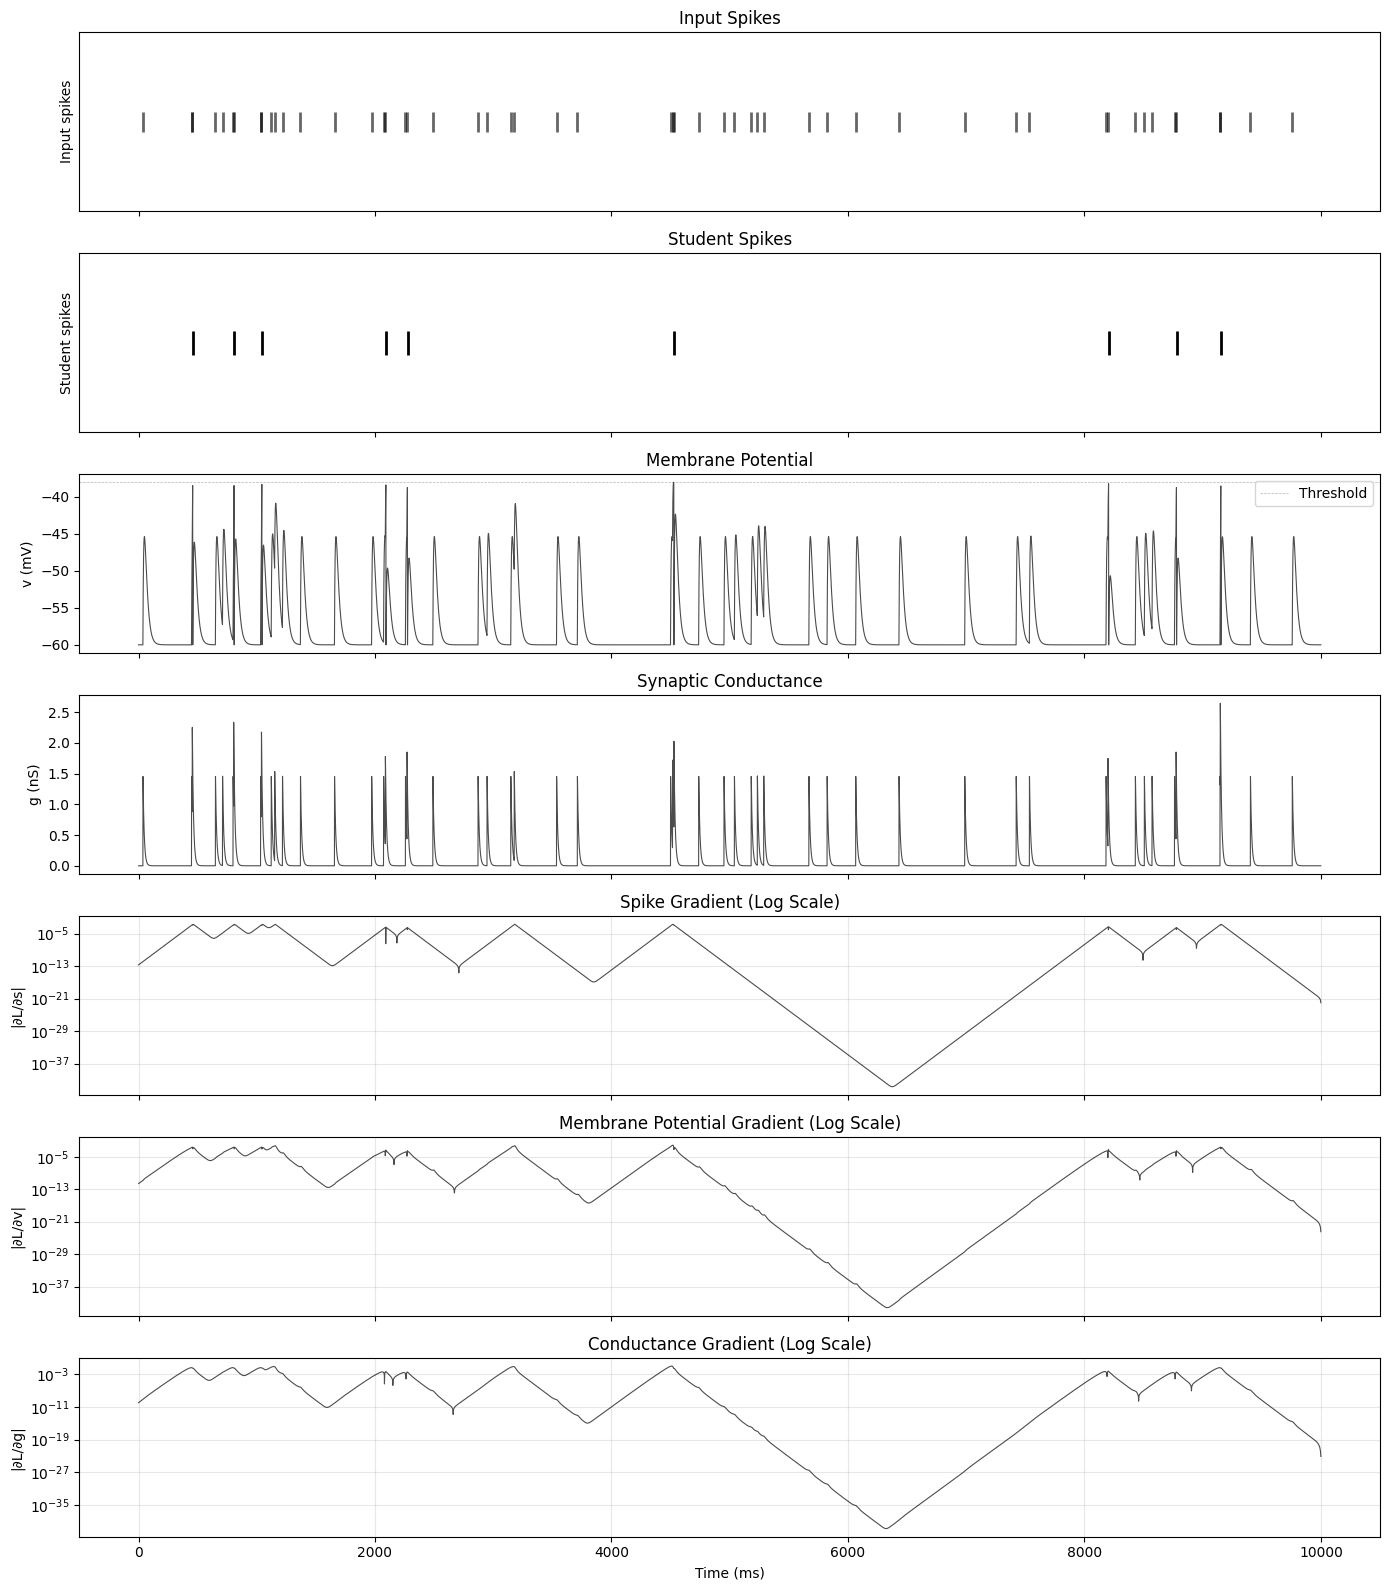

Gradient w.r.t. log_w_student: -1.073709


In [12]:
# Plot student network dynamics and gradients (last 1000 timesteps only)
plot_steps = min(10000, time_steps)
start_idx = time_steps - plot_steps

# Slice data for plotting
time_plot = time_axis[-plot_steps:].numpy()
v_plot = v_student[0, -plot_steps:].detach().numpy()
g_plot = g_student[0, -plot_steps:].detach().numpy()
spike_grad_plot = torch.abs(s_student.grad[0, -plot_steps:]).numpy()
v_grad_plot = torch.abs(v_grad_tensor[0, -(plot_steps - 1) :]).numpy()
g_grad_plot = torch.abs(g_grad_tensor[0, -plot_steps:]).numpy()

# Filter spike times to plot window
input_spike_times = torch.nonzero(input_spikes[0], as_tuple=True)[0].numpy() * dt
input_spike_times = input_spike_times[input_spike_times >= time_plot[0]]
student_spike_times = torch.nonzero(s_student[0], as_tuple=True)[0].numpy() * dt
student_spike_times = student_spike_times[student_spike_times >= time_plot[0]]

fig, axes = plt.subplots(7, 1, figsize=(14, 16), sharex=True)

# Plot 1: Input spikes
ax = axes[0]
ax.scatter(
    input_spike_times,
    [0] * len(input_spike_times),
    marker="|",
    s=200,
    c="black",
    alpha=0.6,
    linewidths=2,
)
ax.set_ylabel("Input spikes")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Input Spikes")
ax.set_yticks([])

# Plot 2: Student spikes
ax = axes[1]
ax.scatter(
    student_spike_times,
    [0] * len(student_spike_times),
    marker="|",
    s=300,
    c="black",
    alpha=1.0,
    linewidths=2,
)
ax.set_ylabel("Student spikes")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Student Spikes")
ax.set_yticks([])

# Plot 3: Membrane potential
ax = axes[2]
ax.plot(time_plot, v_plot, "k-", alpha=0.7, linewidth=0.8)
ax.axhline(
    y=theta, color="k", linestyle="--", alpha=0.3, linewidth=0.5, label="Threshold"
)
ax.set_ylabel("v (mV)")
ax.set_title("Membrane Potential")
ax.legend(loc="upper right")

# Plot 4: Conductance
ax = axes[3]
ax.plot(time_plot, g_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("g (nS)")
ax.set_title("Synaptic Conductance")

# Plot 5: Spike gradient (log scale)
ax = axes[4]
ax.semilogy(time_plot, spike_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂s|")
ax.set_title("Spike Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

# Plot 6: Membrane potential gradient (log scale)
ax = axes[5]
ax.semilogy(time_plot[1:], v_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂v|")
ax.set_title("Membrane Potential Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

# Plot 7: Conductance gradient (log scale)
ax = axes[6]
ax.semilogy(time_plot, g_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂g|")
ax.set_xlabel("Time (ms)")
ax.set_title("Conductance Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Gradient w.r.t. log_w_student: {log_w_student.grad.item():.6f}")

In [13]:
# Setup training
optimizer = torch.optim.Adam([log_w_student], lr=0.03)
n_epochs = 100

# Track training history
weight_history = []
loss_history = []

# Training loop
pbar = tqdm(range(n_epochs), desc="Training")
for epoch in pbar:
    # Reset loss state
    loss_fn.reset()

    # Update global weight from log weight
    w = torch.exp(log_w_student)

    # Run student network
    v_student, g_student, s_student, _, _ = conductance_neuron(
        v_init, g_init, input_spikes
    )

    # Compute loss
    loss = loss_fn(s_student, s_teacher)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track history
    weight_history.append(torch.exp(log_w_student).detach().clone())
    loss_history.append(loss.item())

    # Update progress bar message
    current_weight = torch.exp(log_w_student).item()
    pbar.set_postfix(
        {
            "Loss": f"{loss.item():.6f}",
            "Weight": f"{current_weight:.4f}",
            "Target": f"{w_teacher.item():.4f}",
        }
    )

Training: 100%|██████████| 100/100 [09:09<00:00,  5.50s/it, Loss=0.000307, Weight=0.5102, Target=0.5000]


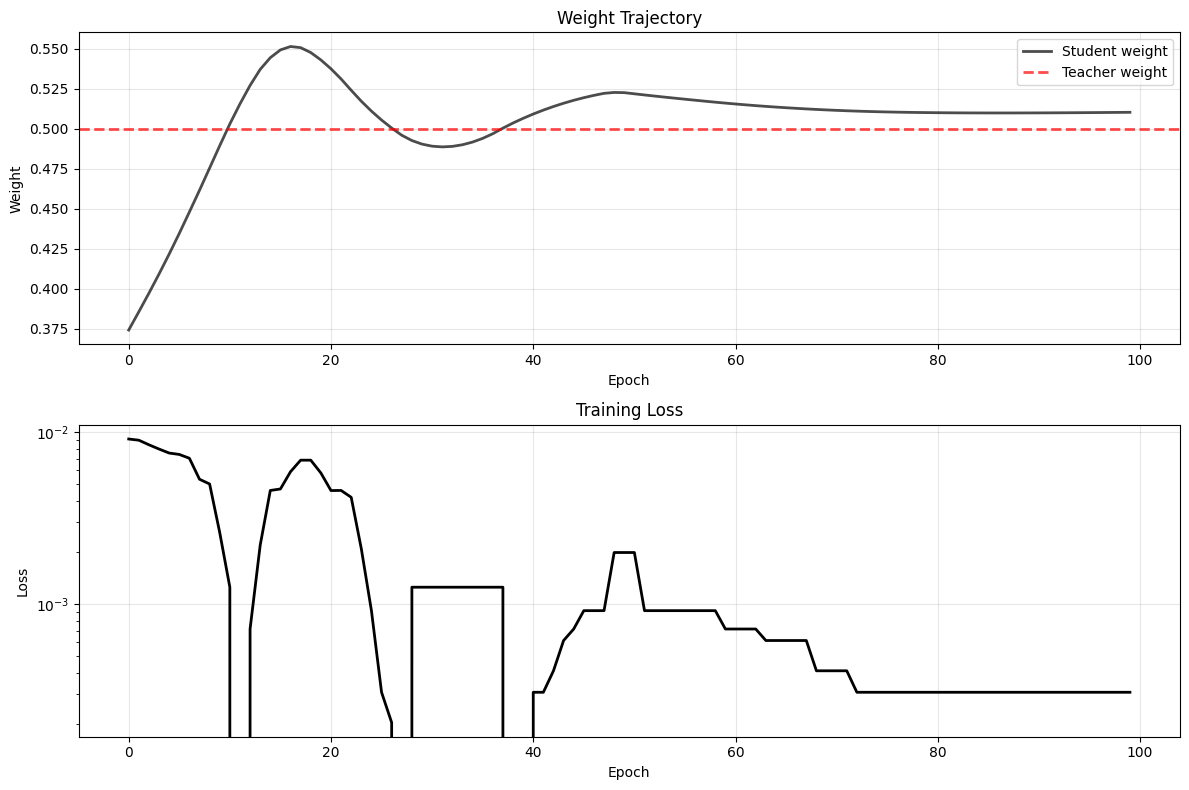

Final weight: Student=0.5102, Teacher=0.5000, Diff=0.0102
Final loss: 0.000307


In [14]:
# Plot training results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Convert histories to arrays
weight_array = torch.stack(weight_history).numpy()  # (n_epochs,)

# Plot 1: Weight trajectory
ax = axes[0]
ax.plot(weight_array, "k-", alpha=0.7, linewidth=2, label="Student weight")
ax.axhline(
    y=w_teacher.item(),
    color="r",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Teacher weight",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("Weight Trajectory")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Loss trajectory
ax = axes[1]
ax.plot(loss_history, "k-", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(
    f"Final weight: Student={weight_array[-1].item():.4f}, Teacher={w_teacher.item():.4f}, Diff={abs(weight_array[-1].item() - w_teacher.item()):.4f}"
)
print(f"Final loss: {loss_history[-1]:.6f}")

In [ ]:
# Redefine the feedforward neuron model with different detach as a comparison
def conductance_neuron_step_no_detach(
    v: torch.Tensor,
    g: torch.Tensor,
    s_in: torch.Tensor,
) -> torch.Tensor:
    """
    Single time step inference of conductance-based LIF neuron model with
    exponential synapses.

    Parameters:
    v: (batch,) membrane potential
    g: (batch,) synaptic conductance
    s_in: (batch,) input spike
    """

    # Update conductance
    g = g * beta + g_syn * w * s_in

    # Update membrane potential
    v = E_L + (v - E_L) * alpha - (g * (v - E_syn)) * dt / C_m

    # Compute spike
    s = SurrGradSpike.apply(v - theta)

    # Reset membrane potential
    v = v * (1 - s) + v_reset * s.detach()

    return v, g, s


def conductance_neuron_no_detach(
    v_init: torch.Tensor,
    g_init: torch.Tensor,
    input_spikes: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, list, list]:
    """
    Multi time step inference of conductance-based LIF neuron model

    Parameters:
    v_init: (batch,) initial membrane potential
    g_init: (batch,) initial synaptic conductance
    input_spikes: (batch, time) input spikes

    Returns:
    v_rec: (batch, time) membrane potentials
    g_rec: (batch, time) conductances
    s_rec: (batch, time) spikes
    v_grads: list of (timestep, gradient) tuples for membrane potential
    g_grads: list of (timestep, gradient) tuples for conductance
    """
    time_steps = input_spikes.shape[1]

    # Initialize state variables
    v = v_init
    g = g_init

    # Record variables over time
    v_list = []
    g_list = []
    s_list = []

    # Store gradients here
    v_grads = []
    g_grads = []

    for t in range(time_steps):
        s_in = input_spikes[:, t]
        v, g, s = conductance_neuron_step_no_detach(v, g, s_in)

        # Register hooks to capture gradients during backward pass
        if v.requires_grad:
            v.register_hook(lambda grad, t=t: v_grads.append((t, grad.clone())))
        if g.requires_grad:
            g.register_hook(lambda grad, t=t: g_grads.append((t, grad.clone())))

        v_list.append(v)
        g_list.append(g)
        s_list.append(s)

    # Stack into tensors
    v_rec = torch.stack(v_list, dim=1)  # (batch, time)
    g_rec = torch.stack(g_list, dim=1)  # (batch, time)
    s_rec = torch.stack(s_list, dim=1)  # (batch, time)

    return v_rec, g_rec, s_rec, v_grads, g_grads

In [16]:
# Reinitialize student network to the same starting weight as the first iteration
log_w_student = log_w_student_initial.clone()
log_w_student.requires_grad = True
w = torch.exp(log_w_student)

In [ ]:
# Run a single diagnostic epoch to visualize what's happening
loss_fn.reset()
w = torch.exp(log_w_student)
v_student, g_student, s_student, v_grads, g_grads = conductance_neuron_no_detach(
    v_init, g_init, input_spikes
)

# Retain gradients for spike output
s_student.retain_grad()

loss = loss_fn(s_student, s_teacher)

# Compute gradients (hooks will capture v and g gradients)
loss.backward(retain_graph=True)

# Convert hook-captured gradients to tensors
if v_grads:
    # Sort by timestep and extract gradients
    v_grads_sorted = sorted(v_grads, key=lambda x: x[0])
    v_grad_tensor = torch.stack(
        [grad for _, grad in v_grads_sorted], dim=1
    )  # (batch, time)
else:
    v_grad_tensor = None

if g_grads:
    g_grads_sorted = sorted(g_grads, key=lambda x: x[0])
    g_grad_tensor = torch.stack(
        [grad for _, grad in g_grads_sorted], dim=1
    )  # (batch, time)
else:
    g_grad_tensor = None

# Convert history lists to tensors for plotting
history_teacher = torch.stack(loss_fn.history_teacher, dim=1)  # (batch, time)
history_student = torch.stack(loss_fn.history_student, dim=1)  # (batch, time)

# Create time axis
time_axis = torch.arange(time_steps) * dt

print(
    f"Captured {len(v_grads)} voltage gradients, {len(g_grads)} conductance gradients"
)
print(f"Spike gradients available: {s_student.grad is not None}")
print(f"Loss: {loss.item():.6f}")
print(
    f"Student weight: {torch.exp(log_w_student).item():.4f}, Teacher weight: {w_teacher.item():.4f}"
)

Captured 9999 voltage gradients, 10000 conductance gradients
Spike gradients available: True
Loss: 0.009140
Student weight: 0.3632, Teacher weight: 0.5000


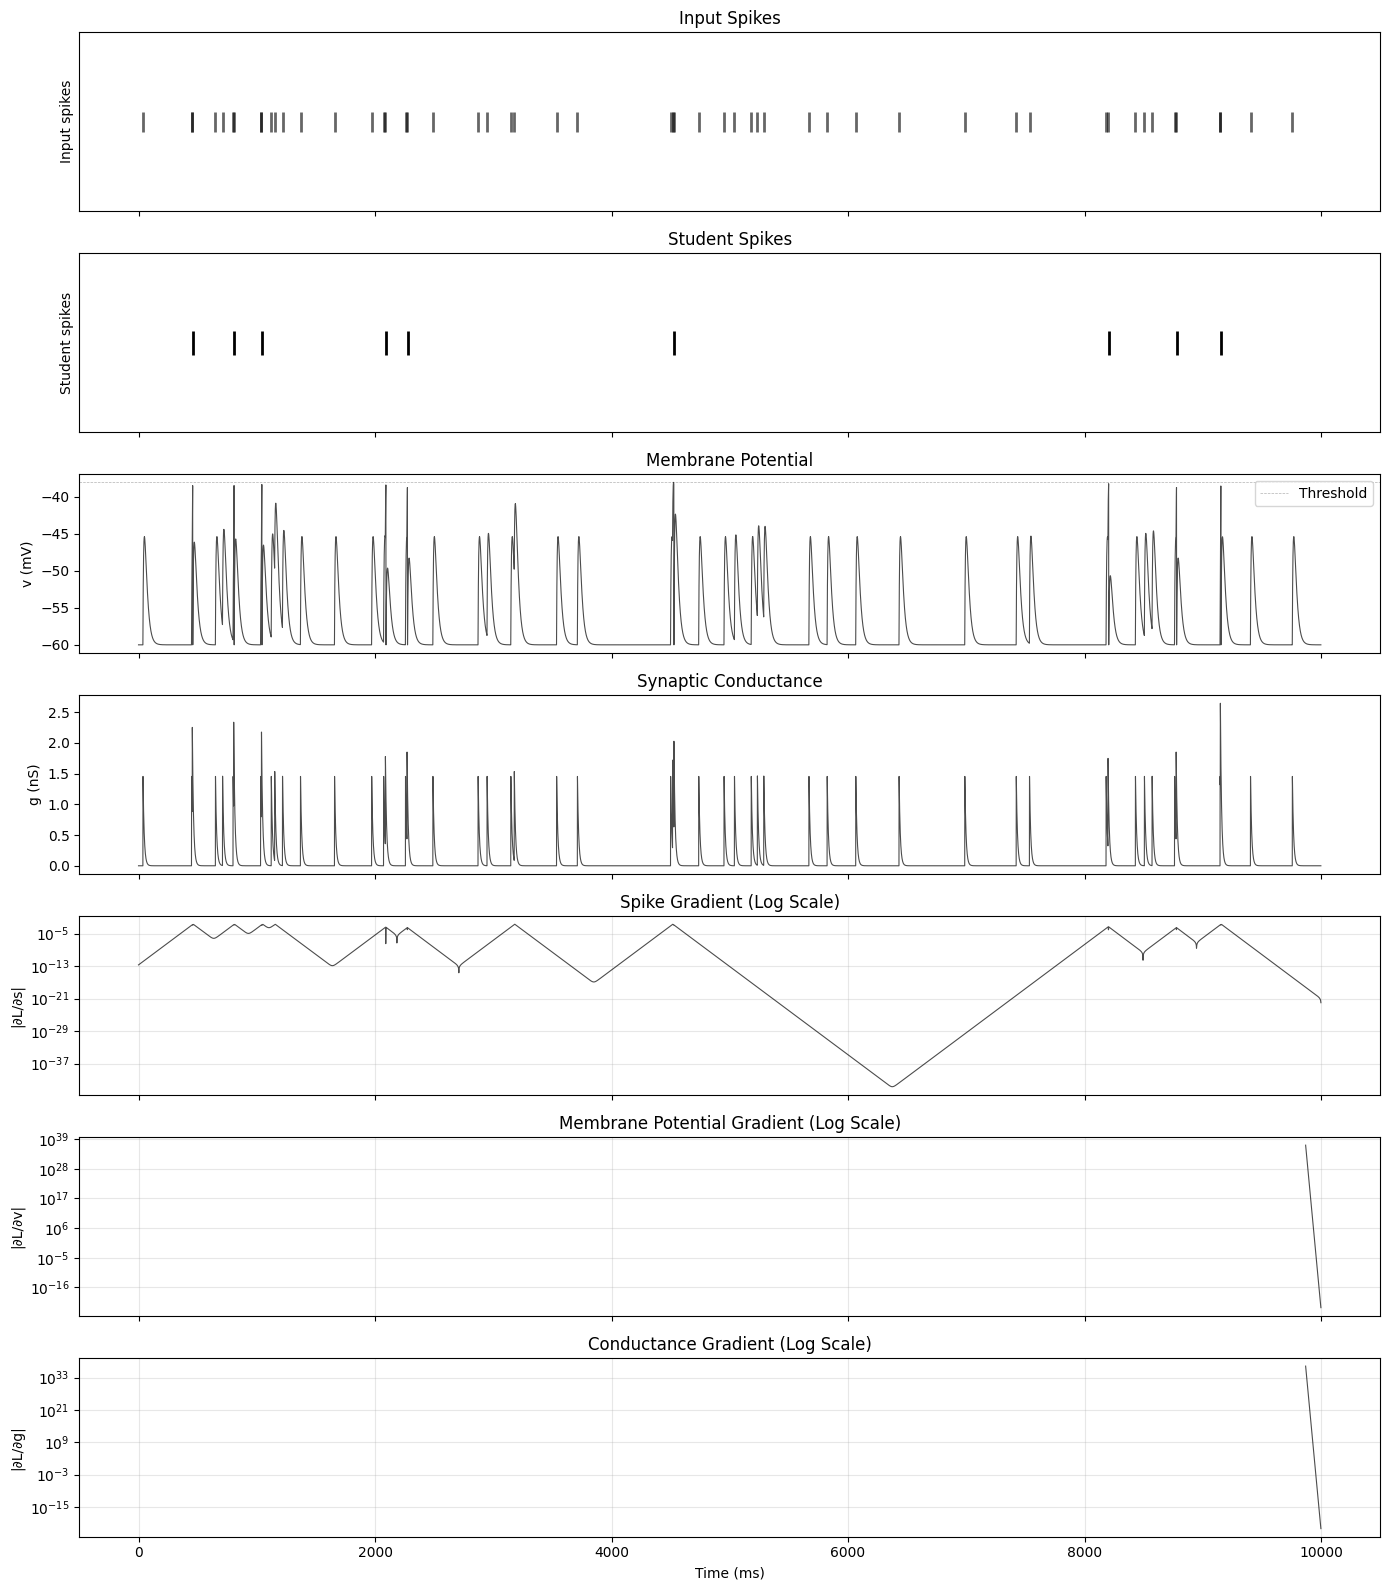

Gradient w.r.t. log_w_student: nan


In [18]:
# Plot student network dynamics and gradients (last 1000 timesteps only)
plot_steps = min(10000, time_steps)
start_idx = time_steps - plot_steps

# Slice data for plotting
time_plot = time_axis[-plot_steps:].numpy()
v_plot = v_student[0, -plot_steps:].detach().numpy()
g_plot = g_student[0, -plot_steps:].detach().numpy()
spike_grad_plot = torch.abs(s_student.grad[0, -plot_steps:]).numpy()
v_grad_plot = torch.abs(v_grad_tensor[0, -(plot_steps - 1) :]).numpy()
g_grad_plot = torch.abs(g_grad_tensor[0, -plot_steps:]).numpy()

# Filter spike times to plot window
input_spike_times = torch.nonzero(input_spikes[0], as_tuple=True)[0].numpy() * dt
input_spike_times = input_spike_times[input_spike_times >= time_plot[0]]
student_spike_times = torch.nonzero(s_student[0], as_tuple=True)[0].numpy() * dt
student_spike_times = student_spike_times[student_spike_times >= time_plot[0]]

fig, axes = plt.subplots(7, 1, figsize=(14, 16), sharex=True)

# Plot 1: Input spikes
ax = axes[0]
ax.scatter(
    input_spike_times,
    [0] * len(input_spike_times),
    marker="|",
    s=200,
    c="black",
    alpha=0.6,
    linewidths=2,
)
ax.set_ylabel("Input spikes")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Input Spikes")
ax.set_yticks([])

# Plot 2: Student spikes
ax = axes[1]
ax.scatter(
    student_spike_times,
    [0] * len(student_spike_times),
    marker="|",
    s=300,
    c="black",
    alpha=1.0,
    linewidths=2,
)
ax.set_ylabel("Student spikes")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Student Spikes")
ax.set_yticks([])

# Plot 3: Membrane potential
ax = axes[2]
ax.plot(time_plot, v_plot, "k-", alpha=0.7, linewidth=0.8)
ax.axhline(
    y=theta, color="k", linestyle="--", alpha=0.3, linewidth=0.5, label="Threshold"
)
ax.set_ylabel("v (mV)")
ax.set_title("Membrane Potential")
ax.legend(loc="upper right")

# Plot 4: Conductance
ax = axes[3]
ax.plot(time_plot, g_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("g (nS)")
ax.set_title("Synaptic Conductance")

# Plot 5: Spike gradient (log scale)
ax = axes[4]
ax.semilogy(time_plot, spike_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂s|")
ax.set_title("Spike Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

# Plot 6: Membrane potential gradient (log scale)
ax = axes[5]
ax.semilogy(time_plot[1:], v_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂v|")
ax.set_title("Membrane Potential Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

# Plot 7: Conductance gradient (log scale)
ax = axes[6]
ax.semilogy(time_plot, g_grad_plot, "k-", alpha=0.7, linewidth=0.8)
ax.set_ylabel("|∂L/∂g|")
ax.set_xlabel("Time (ms)")
ax.set_title("Conductance Gradient (Log Scale)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Gradient w.r.t. log_w_student: {log_w_student.grad.item():.6f}")

In [19]:
# Setup training
optimizer = torch.optim.Adam([log_w_student], lr=0.03)
n_epochs = 100

# Track training history
weight_history = []
loss_history = []

# Training loop
pbar = tqdm(range(n_epochs), desc="Training")
for epoch in pbar:
    # Reset loss state
    loss_fn.reset()

    # Update global weight from log weight
    w = torch.exp(log_w_student)

    # Run student network
    v_student, g_student, s_student, _, _ = conductance_neuron(
        v_init, g_init, input_spikes
    )

    # Compute loss
    loss = loss_fn(s_student, s_teacher)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track history
    weight_history.append(torch.exp(log_w_student).detach().clone())
    loss_history.append(loss.item())

    # Update progress bar message
    current_weight = torch.exp(log_w_student).item()
    pbar.set_postfix(
        {
            "Loss": f"{loss.item():.6f}",
            "Weight": f"{current_weight:.4f}",
            "Target": f"{w_teacher.item():.4f}",
        }
    )

Training: 100%|██████████| 100/100 [08:06<00:00,  4.86s/it, Loss=0.023415, Weight=nan, Target=0.5000]


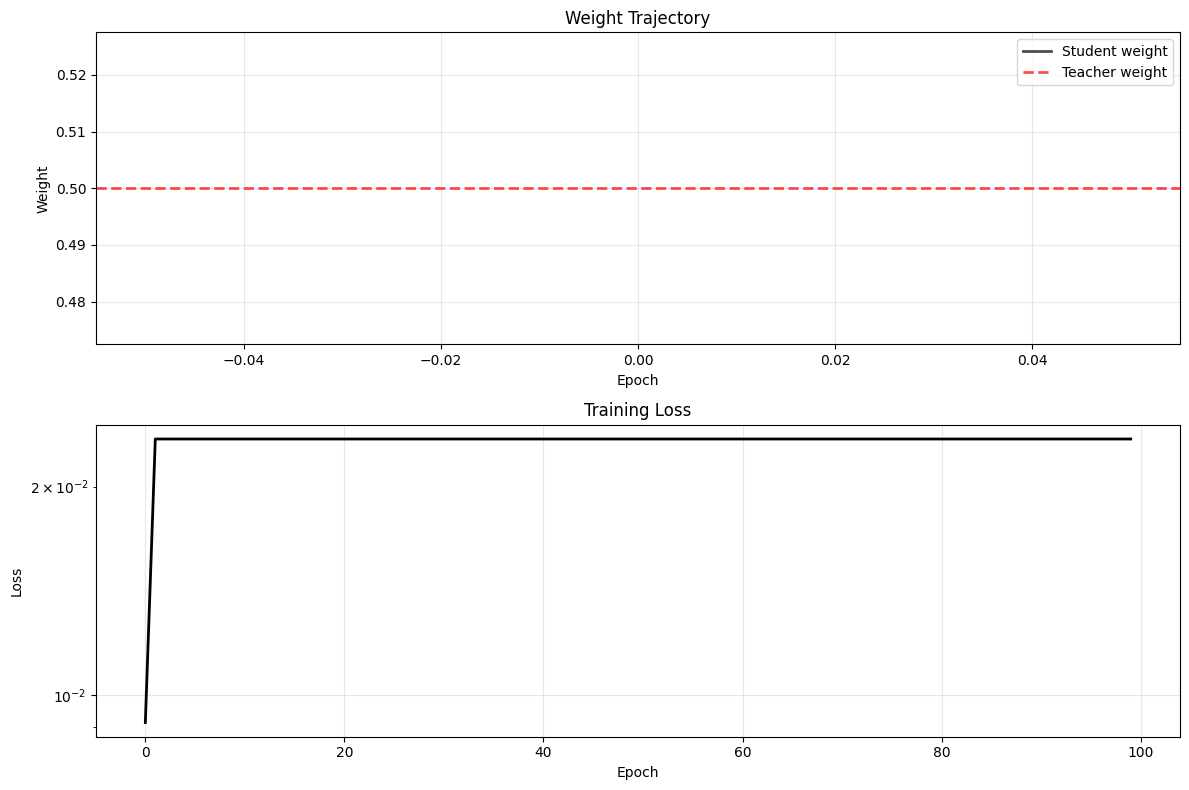

Final weight: Student=nan, Teacher=0.5000, Diff=nan
Final loss: 0.023415


In [20]:
# Plot training results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Convert histories to arrays
weight_array = torch.stack(weight_history).numpy()  # (n_epochs,)

# Plot 1: Weight trajectory
ax = axes[0]
ax.plot(weight_array, "k-", alpha=0.7, linewidth=2, label="Student weight")
ax.axhline(
    y=w_teacher.item(),
    color="r",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Teacher weight",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("Weight Trajectory")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Loss trajectory
ax = axes[1]
ax.plot(loss_history, "k-", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(
    f"Final weight: Student={weight_array[-1].item():.4f}, Teacher={w_teacher.item():.4f}, Diff={abs(weight_array[-1].item() - w_teacher.item()):.4f}"
)
print(f"Final loss: {loss_history[-1]:.6f}")